In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Dataset/FFIV_Stock.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.75 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 198ms/step - loss: 0.1843 - val_loss: 0.0145
Epoch 2/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0207 - val_loss: 0.0102
Epoch 3/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0117 - val_loss: 0.0031
Epoch 4/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0085 - val_loss: 0.0012
Epoch 5/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0058 - val_loss: 9.4839e-04
Epoch 6/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0038 - val_loss: 6.3593e-04
Epoch 7/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0024 - val_loss: 4.7723e-04
Epoch 8/100
14/14 [==============================] - 1s 68ms/step - loss: 0.0015 - val_loss: 4.1442e-04
Epoch 9/100
14/14 [==============================] - 1s 81ms/step - loss: 0.0012 - val_loss: 4.7292e-04
Epoch 10/100
14/14 [==============================] - 1s 94ms/step - loss: 0.0

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

8/8 [==============================] - 0s 12ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
# y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 170.21738647000075


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.4918511]
272
1 day input [0.28296121 0.28118039 0.28436044 0.28143485 0.29962477 0.31412581
 0.29987913 0.30929206 0.32710039 0.33059847 0.34471792 0.34166509
 0.33136165 0.34598992 0.36666028 0.36303507 0.36271704 0.35425808
 0.35743814 0.34605358 0.34757995 0.34999682 0.3534949  0.35762893
 0.36952231 0.3804617  0.37632767 0.38771222 0.39070148 0.3726388
 0.35050564 0.34541753 0.34280987 0.34236471 0.35489413 0.34516317
 0.35120526 0.35432165 0.35343124 0.35419452 0.33466893 0.33625896
 0.36252625 0.36977677 0.36742356 0.3764549  0.35813775 0.36608789
 0.37651847 0.38256055 0.37232077 0.37060361 0.37944416 0.43522225
 0.40920943 0.41340712 0.41645995 0.43051583 0.44094641 0.43477709
 0.45004132 0.43846597 0.4466069  0.44056482 0.43617633 0.42727211
 0.42326531 0.42867135 0.41340712 0.41372515 0.41118104 0.41194432
 0.41735036 0.41684154 0.43077019 0.41499715 0.42447365 0.43420471
 0.44927814 0.45913633 0.46498761 0.4710297  0.47090247 0.46600525
 0.45093173 0.44520767 0.44590729 0

In [14]:
# 13. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.4918511]
272
1 day input [0.28296121 0.28118039 0.28436044 0.28143485 0.29962477 0.31412581
 0.29987913 0.30929206 0.32710039 0.33059847 0.34471792 0.34166509
 0.33136165 0.34598992 0.36666028 0.36303507 0.36271704 0.35425808
 0.35743814 0.34605358 0.34757995 0.34999682 0.3534949  0.35762893
 0.36952231 0.3804617  0.37632767 0.38771222 0.39070148 0.3726388
 0.35050564 0.34541753 0.34280987 0.34236471 0.35489413 0.34516317
 0.35120526 0.35432165 0.35343124 0.35419452 0.33466893 0.33625896
 0.36252625 0.36977677 0.36742356 0.3764549  0.35813775 0.36608789
 0.37651847 0.38256055 0.37232077 0.37060361 0.37944416 0.43522225
 0.40920943 0.41340712 0.41645995 0.43051583 0.44094641 0.43477709
 0.45004132 0.43846597 0.4466069  0.44056482 0.43617633 0.42727211
 0.42326531 0.42867135 0.41340712 0.41372515 0.41118104 0.41194432
 0.41735036 0.41684154 0.43077019 0.41499715 0.42447365 0.43420471
 0.44927814 0.45913633 0.46498761 0.4710297  0.47090247 0.46600525
 0.45093173 0.44520767 0.44590729 0

In [15]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.4918511]
272
1 day input [0.28296121 0.28118039 0.28436044 0.28143485 0.29962477 0.31412581
 0.29987913 0.30929206 0.32710039 0.33059847 0.34471792 0.34166509
 0.33136165 0.34598992 0.36666028 0.36303507 0.36271704 0.35425808
 0.35743814 0.34605358 0.34757995 0.34999682 0.3534949  0.35762893
 0.36952231 0.3804617  0.37632767 0.38771222 0.39070148 0.3726388
 0.35050564 0.34541753 0.34280987 0.34236471 0.35489413 0.34516317
 0.35120526 0.35432165 0.35343124 0.35419452 0.33466893 0.33625896
 0.36252625 0.36977677 0.36742356 0.3764549  0.35813775 0.36608789
 0.37651847 0.38256055 0.37232077 0.37060361 0.37944416 0.43522225
 0.40920943 0.41340712 0.41645995 0.43051583 0.44094641 0.43477709
 0.45004132 0.43846597 0.4466069  0.44056482 0.43617633 0.42727211
 0.42326531 0.42867135 0.41340712 0.41372515 0.41118104 0.41194432
 0.41735036 0.41684154 0.43077019 0.41499715 0.42447365 0.43420471
 0.44927814 0.45913633 0.46498761 0.4710297  0.47090247 0.46600525
 0.45093173 0.44520767 0.44590729 0

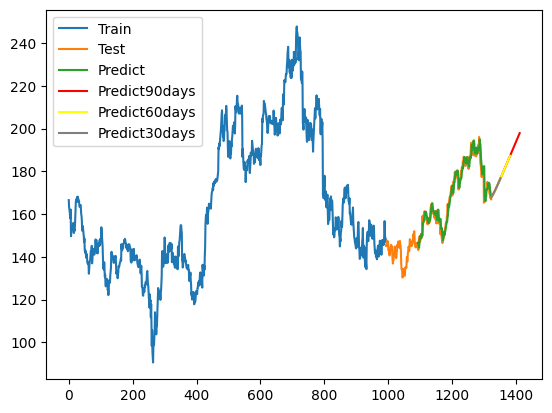

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()